# Plot uni-mutational fractions

Draws histograms of $\dfrac{N_2}{N_2 + N_3 + N_4}$ over all nth-CP positions in each sequence.

Supports first filtering to "mutated" positions.

In [1]:
%run "ComputeUniMutationalFractions.ipynb"

In [15]:
from collections import defaultdict
from parse_sco import parse_sco

def is_position_mutated(seq, pos, minfreq):
    # based on GeneUtils' get_val() func
    if minfreq is None:
        return True
    else:
        mismatchct = seq2pos2mismatchct[seq][str(pos)]
        matchct = seq2pos2matchct[seq][str(pos)]
        cov = mismatchct + matchct
        return (mismatchct / cov) > minfreq

def plot_unimut_frac_hists(minfreq=None, figfilename=None):
    fig, axes = pyplot.subplots(3, 4, sharey="row")

    for figrow, seq in enumerate(SEQS):
        df = parse_sco(
            "/home/marcus/PevznerLabBigData/20201202_big_nonhaplo_oldgfa_graph/20201216_edges/prodigal/{}_genes.sco".format(seq)
        )
        
        # used to populate the text in the uni-mutational fraction section
        num_mutated_positions = defaultdict(int)
        
        # Go through each gene in this sequence. Find the CPs (and non-coding positions).
        # Record each position's "f" value, if present. Plot
        # a histogram of these f-values. (CP 4 is shorthand for "non-coding".)
        num2fvals = {1: [], 2: [], 3: [], 4: []}
        bases_in_genes = set()
        for gene in df.itertuples():
            i = 1
            pos_interval = get_pos_interval_from_gene(gene)
            bases_in_genes |= set(pos_interval)
            for pos in pos_interval:
                if is_position_mutated(seq, pos, minfreq):
                    num_mutated_positions[i] += 1
                    f = seq2pos2f[seq][str(pos)]
                    # Can use this if statement to filter out certain f-values, e.g. < 1
                    if f is not None:
                        num2fvals[i].append(f)
                if i == 1:
                    i = 2
                elif i == 2:
                    i = 3
                elif i == 3:
                    i = 1
                else:
                    raise ValueError("Codon position modulo calculation is broken :|")

            if i != 1:
                raise ValueError("Gene length not divisible by 3.")

        bases_not_in_genes = set(range(1, seq2len[seq] + 1)) - bases_in_genes
        for pos in bases_not_in_genes:
            if is_position_mutated(seq, pos, minfreq):
                num_mutated_positions["NC"] += 1
                f = seq2pos2f[seq][str(pos)]
                if f is not None:
                    num2fvals[4].append(f)

        print("{}: Number of mutated positions using minfreq = {}: {}".format(
            seq2name[seq], minfreq, num_mutated_positions
        ))
        for figcol, cp in enumerate([1, 2, 3, 4]):
            print("{}, CP {}: mean (valid) f-value = {}, num valid f-values = {:,}".format(
                seq2name[seq], cp, mean(num2fvals[cp]), len(num2fvals[cp])
            ))
            ax = axes[figrow, figcol]
            ax.hist(num2fvals[cp], bins=20, color=cp2color[cp], edgecolor=BORDERCOLOR)
            if cp != 4:
                ax.set_title("{}: CP {} Positions".format(seq2name[seq], cp))
            else:
                ax.set_title("{}: Non-Coding Positions".format(seq2name[seq]))
                
            # We don't set the xlim to (0, 1) because doing that kinda cuts off the right border on the
            # bars which looks gross
            ax.set_xlim(0)
            ax.set_xlabel(r"Uni-mutational fraction")
            ax.set_ylabel("Frequency")
            use_thousands_sep(ax.get_yaxis())
            # This is a hack to make all CP plots in a row have the same y-axis. Ideally this'd be automatic
            # but uhhhh elbow grease is easier lol
    #         if seq2name[seq] == "CAMP":
    #             pyplot.ylim(0, 28000)
    #         elif seq2name[seq] == "BUT":
    #             pyplot.ylim(0, 18000)
    #         else:
    #             pyplot.ylim(0, 35000)
    #         pyplot.show()

    if minfreq is None:
        suptitle = "Uni-mutational fractions (all valid values)"
    else:
        suptitle = "Uni-mutational fractions (just positions with mutation frequency > {}%)".format(minfreq * 100)
    fig.suptitle(
        suptitle,
        fontsize="17",
        y=0.93
    )
    fig.set_size_inches(25, 20)
    if figfilename is not None:
        fig.savefig("figs/{}".format(figfilename), bbox_inches="tight")

## Draw plots with $minfreq = 0.5%$

Shown in the main text as of writing.

CAMP: Number of mutated positions using minfreq = 0.005: defaultdict(<class 'int'>, {1: 199, 3: 396, 2: 163, 'NC': 98})
CAMP, CP 1: mean (valid) f-value = 0.9530019498842793, num valid f-values = 199
CAMP, CP 2: mean (valid) f-value = 0.9577480263767123, num valid f-values = 163
CAMP, CP 3: mean (valid) f-value = 0.9800998156508952, num valid f-values = 396
CAMP, CP 4: mean (valid) f-value = 0.9475311376120656, num valid f-values = 98
BUT: Number of mutated positions using minfreq = 0.005: defaultdict(<class 'int'>, {3: 1325, 1: 673, 2: 606, 'NC': 486})
BUT, CP 1: mean (valid) f-value = 0.9510841363384813, num valid f-values = 673
BUT, CP 2: mean (valid) f-value = 0.936973192407906, num valid f-values = 606
BUT, CP 3: mean (valid) f-value = 0.9647703307048172, num valid f-values = 1,325
BUT, CP 4: mean (valid) f-value = 0.9416070964510982, num valid f-values = 486
BACT: Number of mutated positions using minfreq = 0.005: defaultdict(<class 'int'>, {1: 556, 3: 749, 2: 439, 'NC': 631})
BA

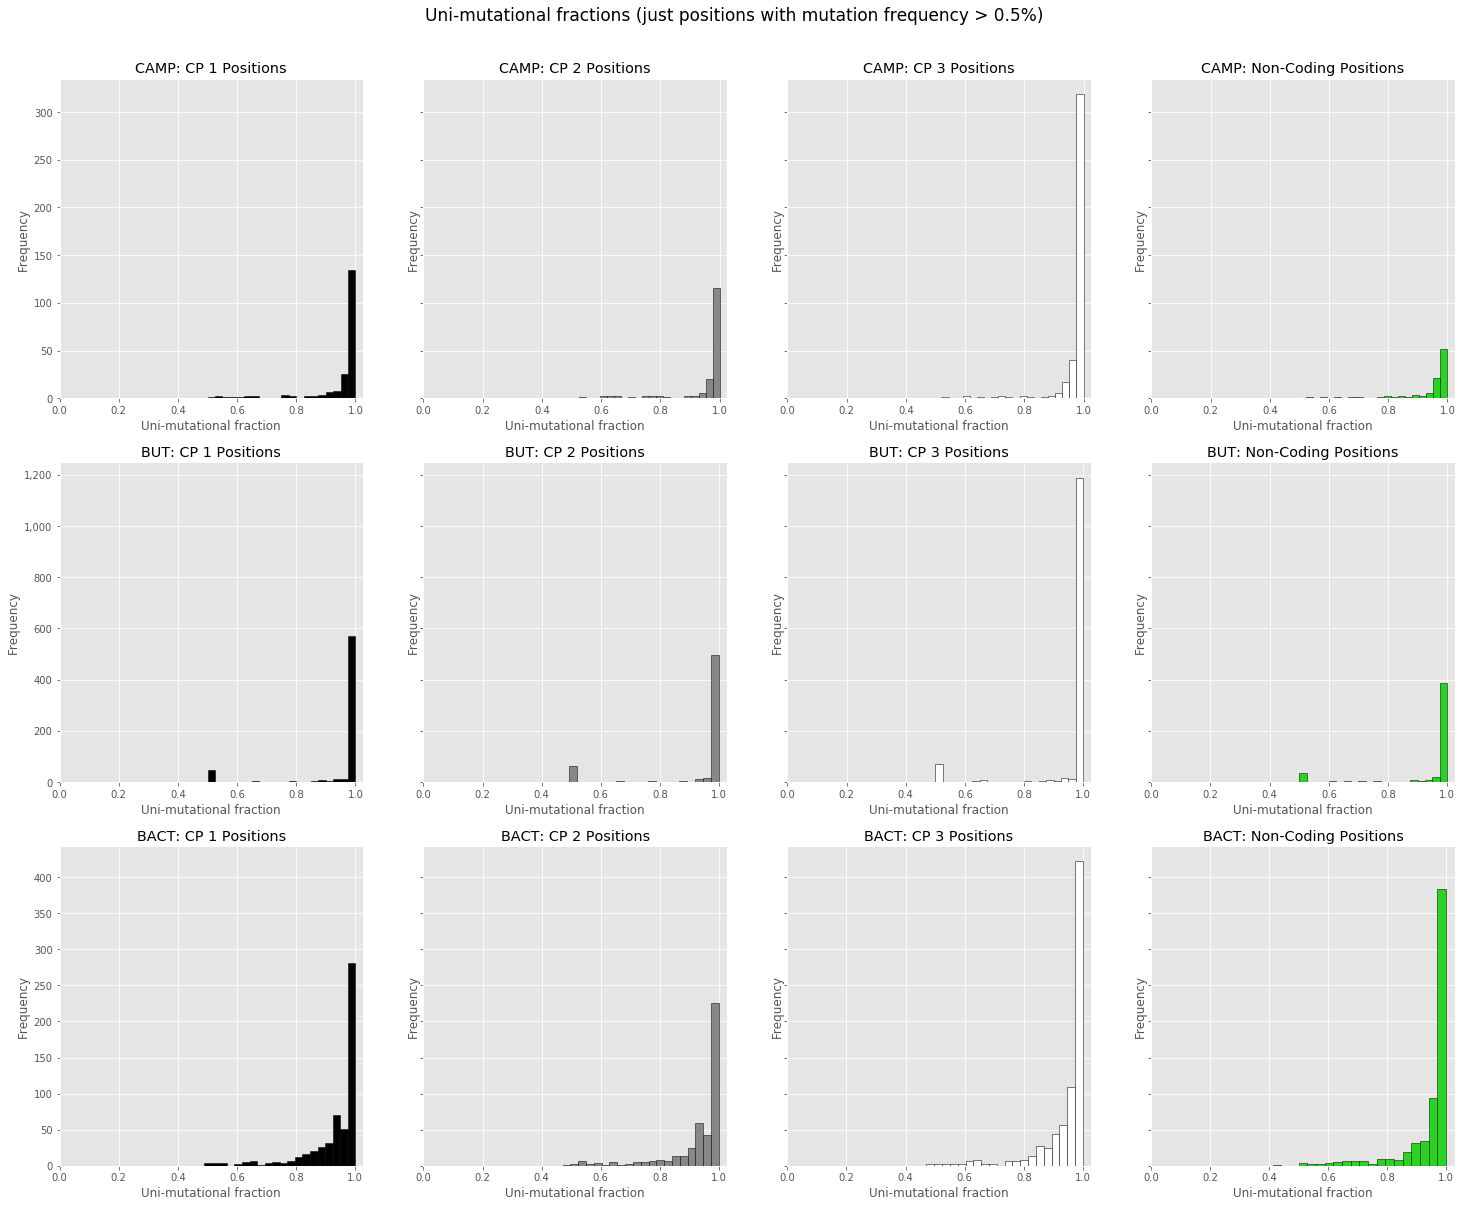

In [16]:
plot_unimut_frac_hists(0.005, figfilename="unimut-fractions-only-mutated-gt-0.5pct.png")

## Draw plots without any $minfreq$

So, all positions with valid uni-mutational fractions (i.e. all mutated positions) are included.

Shown in the appendix as of writing.

CAMP: Number of mutated positions using minfreq = None: defaultdict(<class 'int'>, {1: 397513, 2: 397513, 3: 397513, 'NC': 100806})
CAMP, CP 1: mean (valid) f-value = 0.9116174285691164, num valid f-values = 213,381
CAMP, CP 2: mean (valid) f-value = 0.906167033532244, num valid f-values = 222,105
CAMP, CP 3: mean (valid) f-value = 0.9057429522198897, num valid f-values = 223,807
CAMP, CP 4: mean (valid) f-value = 0.8950599056321636, num valid f-values = 63,216
BUT: Number of mutated positions using minfreq = None: defaultdict(<class 'int'>, {1: 494836, 2: 494836, 3: 494836, 'NC': 154691})
BUT, CP 1: mean (valid) f-value = 0.935449762380203, num valid f-values = 171,084
BUT, CP 2: mean (valid) f-value = 0.9330492521629817, num valid f-values = 177,240
BUT, CP 3: mean (valid) f-value = 0.9307000198511338, num valid f-values = 180,300
BUT, CP 4: mean (valid) f-value = 0.9290660857555323, num valid f-values = 53,813
BACT: Number of mutated positions using minfreq = None: defaultdict(<clas

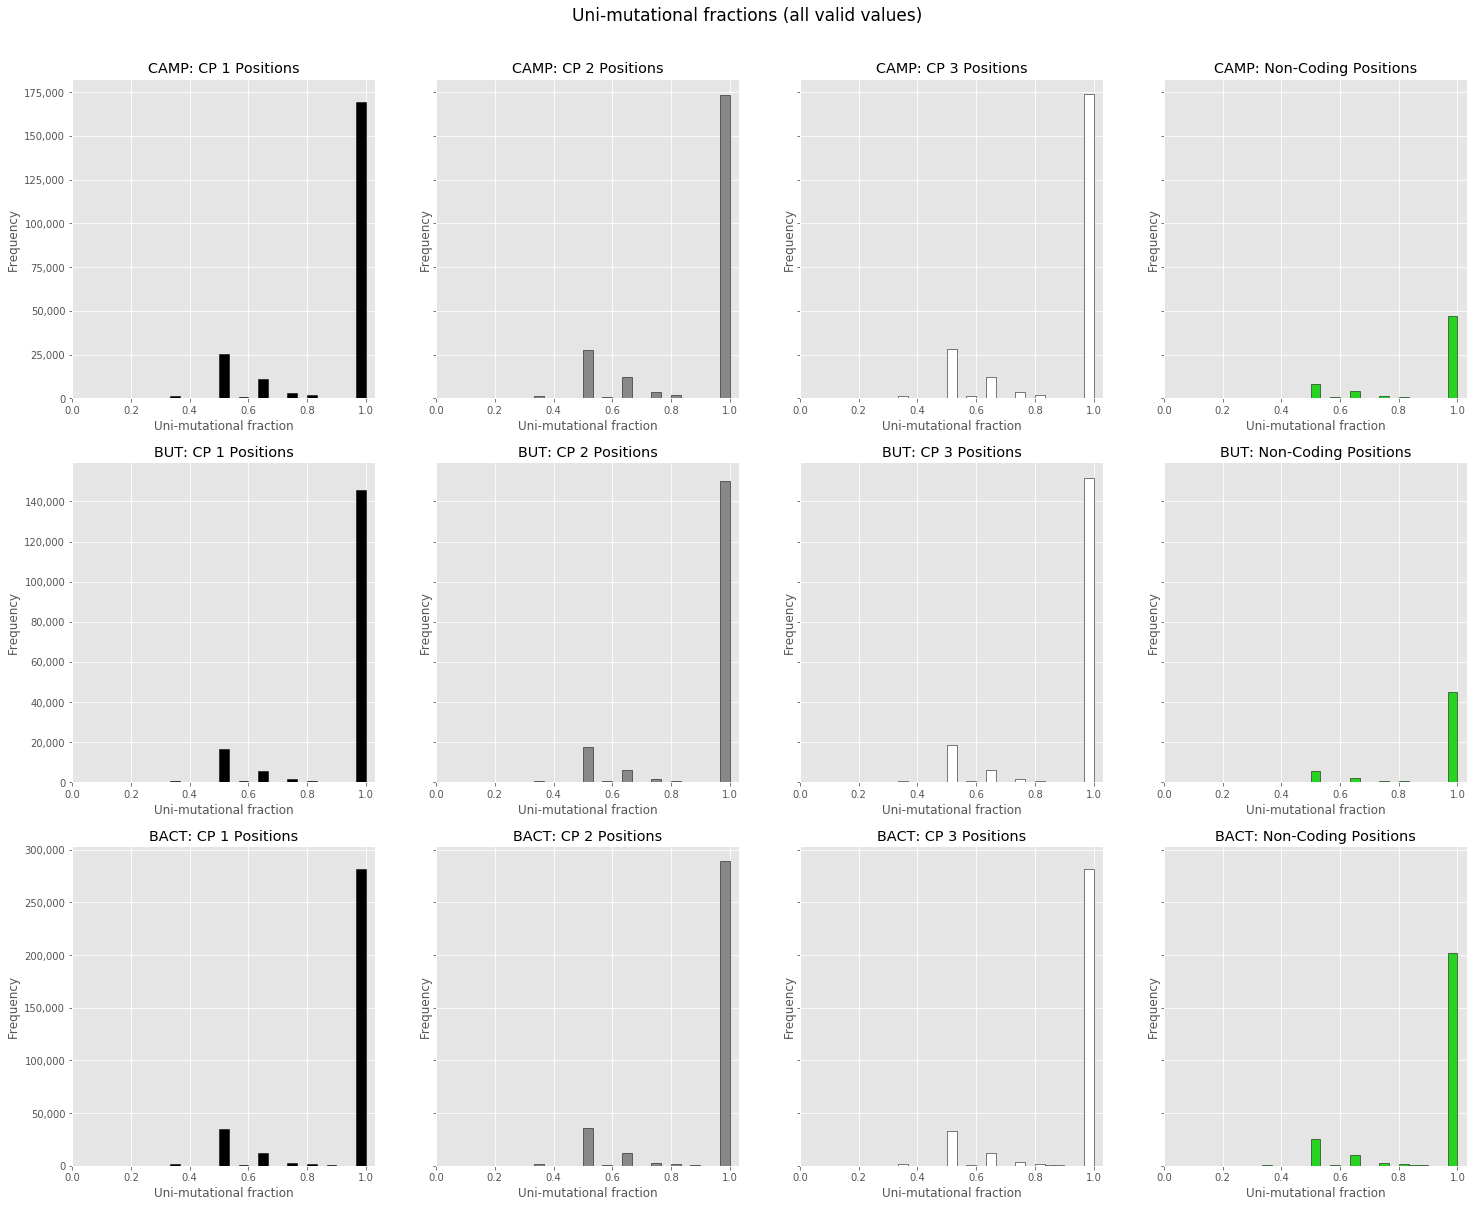

In [17]:
plot_unimut_frac_hists(figfilename="unimut-fractions-all.png")